In [4]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 13.2 MB/s eta 0:00:00


In [5]:
!pip install gymnasium[atari]
!pip install autorom[accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 8.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=4878caa2ae3c9307c5d5cb69ebc80b72a8cb03a5ce95ff4b29e46e369e6c093c
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


In [6]:

!pip install tqdm

In [7]:
!pip install -q swig
!pip install -q gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [8]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
from tqdm import tqdm

import random

In [ ]:
from ale_py import ALEInterface
ale = ALEInterface()

from ale_py.roms import SpaceInvaders
ale.loadROM(SpaceInvaders)

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available!")
else:
    device = torch.device("cpu")
    print("GPU is not available. Switching to CPU.")

GPU is not available. Switching to CPU.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()

        # Define linear layers
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128,64)
        self.fc4  = nn.Linear(64,output_size)

    def forward(self, x):
        # Forward pass through the network
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x=self.relu(x)
        x=self.fc4(x)
        return x

In [26]:
class ExperienceReplay:
    def __init__(self):
      self.buffer = []


    def push(self, state, action, reward, next_state,done):

        self.buffer.append((state, action, reward, next_state,done))


    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)

        return batch


    def __len__(self):
        return len(self.buffer)

In [29]:

class DDQN:
  def __init__(self,input_size,output_size,env,gamma,tau,batch_size,decay):


      self.output_size = output_size
      self.input_size = input_size

      self.Primary_Agent = DQN(self.input_size,self.output_size).to(device)
      self.optimizer  = torch.optim.Adam(self.Primary_Agent.parameters(), lr=0.05)

      self.Target_Agent = DQN(self.input_size,self.output_size).to(device)



      self.env  =env
      self.gamma = gamma
      self.tau = tau


      self.batch_size = batch_size
      self.ExperienceReplayer = ExperienceReplay()
      self.target_network_update_period = 4


      self.decay = decay
      self.max_epsilon =1.0
      self.min_epsilon = 0.01

      self.criterion = nn.MSELoss()
      # self.epsilon = 0.99


  def Train(self,episodes):
    Episodes = []
    Rewards = []
    self.episodes = episodes


    for episode in tqdm(range(self.episodes)):
      self.epsilon = self.min_epsilon + (self.max_epsilon-self.min_epsilon)*np.exp(-self.decay*episode)
      # self.epsilon *= self.decay
      Episodes.append(episode)
      curr_state = self.env.reset()
      self.ind =0
      curr_state = curr_state[0]

      Reward =0

      while(True):

        curr_state = torch.tensor(curr_state, dtype=torch.float32)
        observation = torch.unsqueeze(curr_state, dim=0).to(device)

        Q_value = self.Primary_Agent.forward(observation)


        final_action = np.argmax(Q_value.cpu().detach().numpy(),axis=1)[0]




        random_variable = np.random.random()
        if(random_variable<=self.epsilon):
          final_action = random.randint(0, 3)




        next_state, reward, terminated,truncated,info = self.env.step(final_action)
        Reward+=reward
        if(terminated or truncated):
          done =1
        else:
          done=0

        next_state = torch.tensor(curr_state, dtype=torch.float32)
        self.ExperienceReplayer.push(curr_state,torch.tensor(final_action,dtype=torch.int64),reward,next_state,done)
        curr_state = next_state

        self.ind+=1

        if((self.ExperienceReplayer.__len__()>=self.batch_size) and (not (self.ind % self.target_network_update_period))):

          Batch = self.ExperienceReplayer.sample(self.batch_size)
          current_states,actions,rewards,next_states,done  = zip(*Batch)




          current_states = torch.stack(current_states, dim=0).to(device)
          next_states = torch.stack(next_states,dim=0).to(device)
          actions = torch.tensor(actions,dtype=torch.int64).to(device)
          rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
          done = torch.tensor(done,dtype=torch.float32).to(device)



          Q1_value= self.Target_Agent.forward(next_states)
          Next_best_actions = np.argmax(Q1_value.cpu().detach().numpy(),axis=1)
          Next_best_actions = torch.tensor(Next_best_actions,dtype=torch.int64).to(device)



          Next_Q_values = self.Primary_Agent.forward(next_states)
          Current_Q_values = self.Primary_Agent.forward(current_states)
          Primary_Q_values = Current_Q_values.gather(1,actions.unsqueeze(1))

          Q_values  = Next_Q_values.gather(1,Next_best_actions.unsqueeze(1))
          A = self.gamma*Q_values
          B  = (1-done).unsqueeze(1)
          C = A*B
          rewards = rewards.unsqueeze(1)

          Expected_Q_values =  rewards+C




          Batch_loss = self.criterion(Primary_Q_values,Expected_Q_values)

          self.optimizer.zero_grad()
          Batch_loss.backward()

          # Update model parameters
          self.optimizer.step()
          Next_best_actions = Next_best_actions.cpu()
          current_states = current_states.cpu()
          next_states = next_states.cpu()
          actions = actions.cpu()
          rewards = rewards.cpu()
          done = done.cpu()



          observation = observation.cpu()

          for tp, lp in zip(self.Target_Agent.parameters(), self.Primary_Agent.parameters()):
                tp.data.copy_(self.tau*lp.data + (1.0-self.tau)*tp.data)




        if(terminated or truncated):
          Rewards.append(Reward)
          break
    #   # print("Episode reward : "  ,Reward)

    plt.plot(Episodes, Rewards, label='Line Plot')

    # Add labels and title
    plt.xlabel('Episode')
    plt.ylabel('Episode Reward')
    plt.title('Double DQNReward vs Episodes')

    # Add a legend
    plt.legend()

    # Display the plot
    plt.show()





  def Test(self):
    curr_state = self.env.reset()

    curr_state = curr_state[0]

    Reward =0
    ind=0
    while(True):
      curr_state = torch.tensor(curr_state, dtype=torch.float32)
      observation = torch.unsqueeze(curr_state, dim=0).to(device)

      Q_value = self.Primary_Agent.forward(observation)

      final_action = np.argmax(Q_value.cpu().detach().numpy(),axis=1)[0]

      next_state, reward, terminated,truncated,info = self.env.step(final_action)
      Reward+=reward


      ind+=1
      if(truncated or terminated):
        break
      curr_state = next_state

    return Reward


  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-29-60ea1c782e6e>:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(curr_state, dtype=torch.float32)
<ipython-input-29-60ea1c782e6e>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  curr_state = torch.tensor(curr_state, dtype=torch.float32)
100%|██████████| 1000/1000 [01:04<00:00, 15.49it/s]


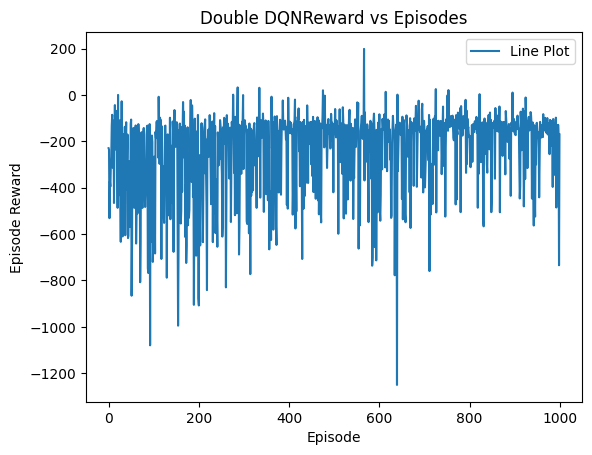

-127.71259682227875


In [30]:

#lists all devices being used in this cell->helps verify if gpu is being used
# env = gym.make('MountainCar-v0')
env = gym.make( "LunarLander-v2")
gamma=0.99
tau=0.4
Episodes=1000

batch_size = 10
input_size = 8
output_size=4

decay = 0.4
Game1 = DDQN(input_size,output_size,env,gamma,tau,batch_size,decay)
Game1.Train(Episodes)
Reward = Game1.Test()
print(Reward)

In [31]:

Rewards =0.0
for i in range(600):
  rewards = Game1.Test()

  Rewards+=rewards

Rewards /=600
print(Rewards)

-133.3799101902124


In [32]:
class DuelingDQN(nn.Module):
    def __init__(self, input_size, output_size):
      super(DuelingDQN, self).__init__()
      self.input_size = input_size
      self.output_size = output_size


      # Define linear layers
      self.fc1 = nn.Linear(input_size, 64)
      self.relu = nn.ReLU()
      self.fc2 = nn.Linear(64, 64)


      self.vc1  = nn.Linear(64,32)
      self.vc2 = nn.Linear(32,1)

      self.ac1 = nn.Linear(64,32)
      self.ac2 = nn.Linear(32,output_size)

    def forward(self, x):
        # Forward pass through the network
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        V = self.vc1(x)
        V =self.relu(V)
        V = self.vc2(V)

        A = self.ac1(x)
        A =self.relu(A)
        A = self.ac2(A)

        Q_s =V + A - A.mean(dim=-1, keepdim=True).expand(-1, self.output_size)

        return Q_s

In [33]:
class DuelingDQN_game:
  def __init__(self,output_size,env,gamma,tau,batch_size,decay):

    self.output_size = output_size
    self.input_size = input_size

    self.Primary_Agent = DuelingDQN(self.input_size,self.output_size).to(device)
    self.optimizer  = torch.optim.Adam(self.Primary_Agent.parameters(), lr=0.05)

    self.Target_Agent = DuelingDQN(self.input_size,self.output_size).to(device)



    self.env  =env
    self.gamma = gamma
    self.tau = tau


    self.batch_size = batch_size
    self.ExperienceReplayer = ExperienceReplay()
    self.target_network_update_period = 4


    self.decay = decay
    self.max_epsilon =1.0
    self.min_epsilon = 0.01
    self.ind =0
    self.criterion = nn.MSELoss()


  def Train(self,episodes):
    Episodes = []
    Rewards = []
    self.episodes = episodes


    for episode in tqdm(range(self.episodes)):
      self.epsilon = self.min_epsilon + (self.max_epsilon-self.min_epsilon)*np.exp(-self.decay*episode)
      Episodes.append(episode)
      curr_state = self.env.reset()

      curr_state = curr_state[0]

      Reward =0

      while(True):

        curr_state = torch.tensor(curr_state, dtype=torch.float32)
        observation = torch.unsqueeze(curr_state, dim=0).to(device)

        Q_value = self.Primary_Agent.forward(observation)


        final_action = np.argmax(Q_value.cpu().detach().numpy(),axis=1)[0]




        random_variable = np.random.random()
        if(random_variable<=self.epsilon):
          final_action = random.randint(0, 3)




        next_state, reward, terminated,truncated,info = self.env.step(final_action)
        Reward+=reward
        if(terminated or truncated):
          done =1
        else:
          done=0

        next_state = torch.tensor(curr_state, dtype=torch.float32)
        self.ExperienceReplayer.push(curr_state,torch.tensor(final_action,dtype=torch.int64),reward,next_state,done)
        curr_state = next_state



        if(self.ExperienceReplayer.__len__()>=self.batch_size):

          Batch = self.ExperienceReplayer.sample(self.batch_size)
          current_states,actions,rewards,next_states,done  = zip(*Batch)




          current_states = torch.stack(current_states, dim=0).to(device)
          next_states = torch.stack(next_states,dim=0).to(device)
          actions = torch.tensor(actions,dtype=torch.int64).to(device)
          rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
          done = torch.tensor(done,dtype=torch.float32).to(device)



          Q1_value= self.Target_Agent.forward(next_states)
          Next_best_actions = np.argmax(Q1_value.cpu().detach().numpy(),axis=1)
          Next_best_actions = torch.tensor(Next_best_actions,dtype=torch.int64).to(device)



          Next_Q_values = self.Primary_Agent.forward(next_states)
          Current_Q_values = self.Primary_Agent.forward(current_states)
          Primary_Q_values = Current_Q_values.gather(1,actions.unsqueeze(1))

          Q_values  = Next_Q_values.gather(1,Next_best_actions.unsqueeze(1))
          A = self.gamma*Q_values
          B  = (1-done).unsqueeze(1)
          C = A*B
          rewards = rewards.unsqueeze(1)

          Expected_Q_values =  rewards+C




          Batch_loss = self.criterion(Primary_Q_values,Expected_Q_values)

          self.optimizer.zero_grad()
          Batch_loss.backward()

          # Update model parameters
          self.optimizer.step()
          Next_best_actions = Next_best_actions.cpu()
          current_states = current_states.cpu()
          next_states = next_states.cpu()
          actions = actions.cpu()
          rewards = rewards.cpu()
          done = done.cpu()



        observation = observation.cpu()


        if((self.ind% self.target_network_update_period)):

          self.Target_Agent.load_state_dict(self.Primary_Agent.state_dict())



        self.ind+=1
        if(terminated or truncated):
          Rewards.append(Reward)
          break
    #   # print("Episode reward : "  ,Reward)

    plt.plot(Episodes, Rewards, label='Line Plot')

    # Add labels and title
    plt.xlabel('Episode')
    plt.ylabel('Episode Reward')
    plt.title('Dueling Reward vs Episodes')

    # Add a legend
    plt.legend()

    # Display the plot
    plt.show()





  def Test(self):
    curr_state = self.env.reset()

    curr_state = curr_state[0]

    Reward =0
    ind=0
    while(True):
      curr_state = torch.tensor(curr_state, dtype=torch.float32)
      observation = torch.unsqueeze(curr_state, dim=0).to(device)

      Q_value = self.Primary_Agent.forward(observation)

      final_action = np.argmax(Q_value.cpu().detach().numpy(),axis=1)[0]

      next_state, reward, terminated,truncated,info = self.env.step(final_action)
      Reward+=reward


      ind+=1
      if(truncated or terminated):
        break
      curr_state = next_state

    return Reward
















  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-33-fa483076d6c8>:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(curr_state, dtype=torch.float32)
<ipython-input-33-fa483076d6c8>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  curr_state = torch.tensor(curr_state, dtype=torch.float32)
100%|██████████| 1000/1000 [03:48<00:00,  4.38it/s]


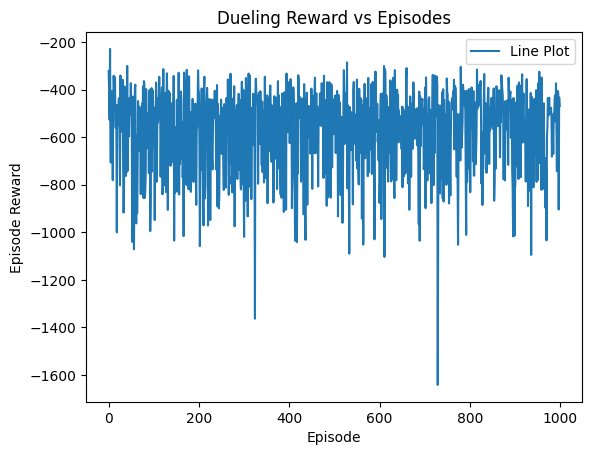

-514.0721153611544


In [34]:
#lists all devices being used in this cell->helps verify if gpu is being used
env = gym.make( "LunarLander-v2")
gamma=0.99
tau=0.4
Episodes=1000
batch_size = 64
input_size = 8
output_size=4

decay = 0.4
Game2 = DuelingDQN_game(output_size,env,gamma,tau,batch_size,decay)
Game2.Train(Episodes)
Reward = Game2.Test()
print(Reward)

In [37]:

Rewards =0.0
for i in range(600):
  rewards = Game2.Test()

  Rewards+=rewards

Rewards /=600
print(Rewards)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-578.924325556876
